In [1]:
from model import DRIT
from options import TestOptions
from dataset import dataset_unpair

import torch
import torchvision.transforms.functional as F
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

parser = TestOptions()
opts = parser.parse(['--dataroot', '../datasets_/nlsclanduse', '--resume',
                     '../results/nlsclanduse-2017-to-2001_zsdim2/00199.pth',
                     '--phase', 'train',
                     '--zs_dim', '2',
                     '--pair_align',
                     '--batch_size', '2',
                     '--crop_size', '256'])

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


--- load options ---
a2b: 1
aux_cls_weights: None
aux_masks: False
aux_n_classes: 2
batch_size: 2
concat: 1
crop_size: 256
dataroot: ../datasets_/nlsclanduse
gpu: 0
input_dim_a: 3
input_dim_b: 3
lr: 0.0001
nThreads: 4
name: trial
no_flip: False
no_ms: False
num: 5
pair_align: True
phase: train
resize_size: 256
result_dir: ../outputs
resume: ../results/nlsclanduse-2017-to-2001_zsdim2/00199.pth
weight_decay: 0.0001
zs_dim: 2


In [2]:
dataset = dataset_unpair(opts)

A: 4190, B: 4190 images


/mnt/Data/anaconda3/envs/gis/lib/python3.7/site-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


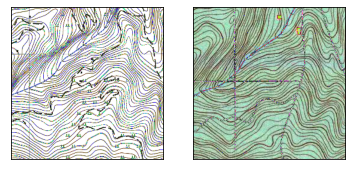

In [32]:
img1, img2 = dataset[4180]

# img1 = tensor2img(img1.view(1, *img1.shape))
# img2 = tensor2img(img2.view(1, *img2.shape))

# print(img1.shape)

show([img1, img2])

imgidx: 3208
torch.Size([1, 3, 256, 256])


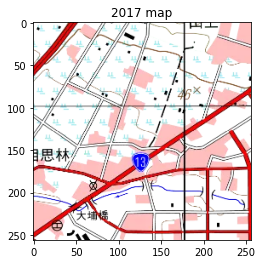

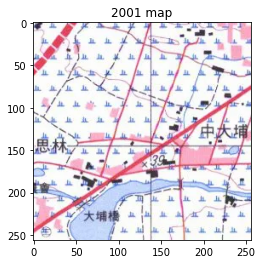

In [149]:
import random
imgidx = random.randint(0, len(datasetA)-1)
# imgidx = 1496
# imgidx = 1483
# imgidx = 370
# imgidx = 1020
imgidx = 3208
print(f'imgidx: {imgidx}')

# 
# ld1it = enumerate(loader)
# for _ in range(skip):
#     next(ld1it)
# idx1, img1 = next(ld1it)
# ld2it = enumerate(loader_attr)
# for _ in range(skip):
#     next(ld2it)
# idx2, img2 = next(ld2it)
img1 = datasetA[imgidx]
img2 = datasetB[imgidx]
img1 = img1.view(1, *img1.size())
img2 = img2.view(1, *img2.size())

from saver import tensor2img
print(img1.shape)
img11 = tensor2img(img1)
img22 = tensor2img(img2)
plt.figure()
plt.title('2017 map')
plt.imshow(img11)
plt.figure()
plt.title('2001 map')
plt.imshow(img22)

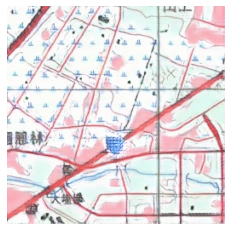

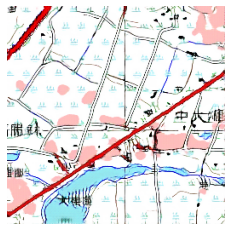

In [87]:
img1 = img1.cuda()
img2 = img2.cuda()

model.input_A = img1
model.mask_A = img1
model.input_B = img2

with torch.no_grad():
    model.forward()

outimg_a2b_ = tensor2img(model.fake_B_encoded)
# plt.title('2017 -> 2001 map')
plt.axis('off')
plt.imshow(outimg_a2b_)
plt.figure()
outimg_b2a_ = tensor2img(model.fake_A_encoded)
# plt.title('2001 -> 2017 map')
plt.axis('off')
plt.imshow(outimg_b2a_)

In [88]:
# print(model.z_attr_b)
val_range = (-10.0, 10.0, 0.1)
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

interact_args = {f'd{i}': val_range for i in range(opts.zs_dim)}
func_args = [0.0 for i in range(opts.zs_dim)]

@interact(cont_sel=['A', 'B'], tdir=['AtoB', 'BtoA'], **interact_args)
def func(cont_sel='A', tdir='AtoB', **args):
    with torch.no_grad():
        dirf = model.gen.forward_b if tdir == 'AtoB' else model.gen.forward_a
        print(model.z_attr_a if tdir == 'AtoB' else model.z_attr_a)
        # [[d1, d2, d3, d4, d5, d6, d7, d8]] = model.z_attr_b.cpu() 
        # outimg = model.gen.forward_b(model.z_content_a, model.z_attr_b)
        # outimg = model.gen.forward_b(model.z_content_a, model.z_attr_a)
        # outimg = model.gen.forward_b(model.z_content_a, torch.ones(model.z_attr_b.shape).cuda())
        # outimg = model.gen.forward_b(model.z_content_a, torch.Tensor([[0, 0, 0, 0, 0, 0, 0, 0]]).cuda())
        outimg = dirf(model.z_content_a
                      if cont_sel == 'A'
                      else model.z_content_b, torch.Tensor([list(args.values())]).cuda())

    outimg_ = tensor2img(outimg)
    plt.imshow(outimg_)

interactive(children=(Dropdown(description='cont_sel', options=('A', 'B'), value='A'), Dropdown(description='t…

In [10]:
print(model.z_content_a.shape)
print(img1.shape)

torch.Size([1, 256, 64, 64])
torch.Size([1, 3, 256, 256])


In [141]:
points = []

with torch.no_grad():
    for img in datasetA:
        # print(img.view(1, *img.shape).shape)
        mu_a, logvar_a = model.enc_a.forward_a(img.cuda().view(1, *img.shape))
        std_a = logvar_a.mul(0.5).exp_()
        eps = torch.randn(std_a.size(0), std_a.size(1)).cuda()
        point = eps.mul(std_a).add_(mu_a)
        points.append(np.array(point.cpu()).squeeze())


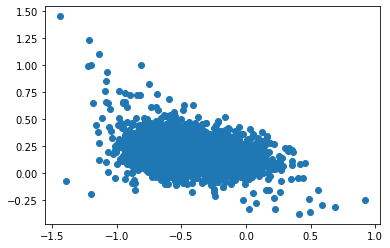

In [148]:
points_ = np.array(points)
plt.scatter(points_[:, 0], points_[:, 1])